In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
def compute_return_numeric(price: pd.Series, ts: pd.Series) -> pd.Series:
    """
    ΔP / Δt où ts est déjà un float64 (ex. secondes depuis epoch).
    """
    return price.diff() / ts.diff()

def create_dataset_vectorized_numeric(
    features_BTC: pd.DataFrame,
    price_ETH:    pd.DataFrame,
    tau_BTC:      int,
    tau_ETH:      int,
    tau_pred:     int,
): 
    """
    X : (N, tau_BTC * k + tau_ETH)
    y : (N,)
    Tous les timestamps sont supposés float64 (ou seront castés).   

    C'est mieux certainement de faire des Moving Average sur le temps et d'utiliser np.research_sorted +>W cf code de Matéo
    """

    # ------------------------------------------------------------------ #
    # 0.  Cast en float64 & tri                                           #
    # ------------------------------------------------------------------ #

    features_BTC.sort_values("timestamp", inplace=True, ignore_index=True)
    price_ETH.sort_values("timestamp",    inplace=True, ignore_index=True)

    # ------------------------------------------------------------------ #
    # 1.  Retour ETH + cible future                                       #
    # ------------------------------------------------------------------ #
    ret_eth = compute_return_numeric(price_ETH["price"], price_ETH["timestamp"])
    ret_eth.name = "return"

    df_ret = pd.concat([price_ETH["timestamp"], ret_eth], axis=1)

    df_ret["target"] = (
        df_ret["return"]
        .rolling(window=tau_pred, min_periods=tau_pred)
        .mean()
        .shift(-tau_pred + 1)
    )
    df_ret = df_ret.dropna(subset=["target"]).reset_index(drop=True)

    ts_y = df_ret["timestamp"].to_numpy()
    y    = df_ret["target"].to_numpy()

    # ------------------------------------------------------------------ #
    # 2.  Fenêtres BTC                                                   #
    # ------------------------------------------------------------------ #
    btc_mat = features_BTC.drop(columns="timestamp").to_numpy()          # (M_btc, k)
    ts_btc  = features_BTC["timestamp"].to_numpy()                       # (M_btc,)

    win_btc = sliding_window_view(
        btc_mat, window_shape=(tau_BTC, btc_mat.shape[1])
    )[:, 0, :, :]                                                        # (⋯, tau_BTC, k)
    win_btc_flat = win_btc.reshape(win_btc.shape[0], -1)                 # (⋯, tau_BTC*k)
    ts_btc_win   = ts_btc[tau_BTC - 1 :]                                 # timestamp fin fenêtre

    idx_btc   = np.searchsorted(ts_btc_win, ts_y, side="right") - 1
    valid_btc = idx_btc >= 0

    # ------------------------------------------------------------------ #
    # 3.  Fenêtres ETH (historique)                                      #
    # ------------------------------------------------------------------ #
    ret_full = ret_eth.fillna(0.0).to_numpy()
    win_eth  = sliding_window_view(ret_full, window_shape=tau_ETH)       # (M_eth, tau_ETH)

    ts_eth   = price_ETH["timestamp"].to_numpy()
    pos_y    = np.searchsorted(ts_eth, ts_y)                             # index de t_y
    idx_eth  = pos_y - tau_ETH
    valid_eth = idx_eth >= 0

    # ------------------------------------------------------------------ #
    # 4.  Masque et assemblage                                           #
    # ------------------------------------------------------------------ #
    mask = valid_btc & valid_eth
    if not np.any(mask):
        raise ValueError("Aucun point ne possède suffisamment d'historique.")

    X_btc = win_btc_flat[idx_btc[mask]]
    X_eth = win_eth[idx_eth[mask]]

    X = np.hstack([X_btc, X_eth])
    y = y[mask]

    return X, y

In [5]:
features_BTC = pd.read_parquet('../data/features/DATA_0/XBT_EUR.parquet')
features_ETH = pd.read_parquet('../data/features/DATA_0/ETH_EUR.parquet')

In [6]:
features_BTC.head(n=100)

,level-1-bid-price,level-1-bid-volume,level-2-bid-price,level-2-bid-volume,level-3-bid-price,level-3-bid-volume,level-4-bid-price,level-4-bid-volume,level-5-bid-price,level-5-bid-volume,...,vwap-bid-5-levels,vwap-ask-5-levels,avg-vwap-diff-5-levels,liquidity-ratio,rate-inst-volatility,rate-momentum,rate-mid-price-trend,rate-vwap-diff-5-levels,rate-bid-volume-level-1,rate-ask-volume-level-1
timestamp,,,,,,,,,,,,,,,,,,,,,
1.748488e+09,96207.1,0.831635,96205.7,2.686969,96204.4,2.310522,96203.500000,0.071820,96202.30000,2.310572,...,0.0,0.0,0.0,0.952914,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,96207.1,0.831635,96205.7,2.686969,96204.4,2.310522,96203.500000,0.071820,96202.30000,2.310572,...,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,96207.1,0.831635,96205.7,2.686969,96204.4,2.310522,96203.500000,0.071820,96202.30000,2.310572,...,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,96207.1,0.831635,96205.7,2.686969,96204.4,2.310522,96203.500000,0.071820,96202.30000,2.310572,...,0.0,0.0,0.0,0.841131,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,96207.1,0.831635,96205.7,2.686969,96204.4,2.310522,96203.500000,0.071820,96202.30000,2.310572,...,0.0,0.0,0.0,1.128582,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.748488e+09,96207.1,0.831635,96204.6,0.376426,96202.6,0.071820,96201.600000,2.310589,96199.20000,2.310648,...,0.0,0.0,0.0,1.146840,2.229034e-23,0.0,96207.15,0.0,0.831635,0.128075
1.748488e+09,96207.1,0.831635,96204.6,0.376426,96202.6,0.071820,96201.600000,2.310589,96199.20000,2.310648,...,0.0,0.0,0.0,1.146840,2.229034e-23,0.0,96207.15,0.0,0.831635,0.128075
1.748488e+09,96207.1,0.831635,96204.6,0.376426,96202.6,0.071820,96201.600000,2.310589,96199.20000,2.310648,...,0.0,0.0,0.0,1.146840,2.229034e-23,0.0,96207.15,0.0,0.831635,0.128075


In [7]:
features_ETH.head()

,level-1-bid-price,level-1-bid-volume,level-2-bid-price,level-2-bid-volume,level-3-bid-price,level-3-bid-volume,level-4-bid-price,level-4-bid-volume,level-5-bid-price,level-5-bid-volume,...,vwap-bid-5-levels,vwap-ask-5-levels,avg-vwap-diff-5-levels,liquidity-ratio,rate-inst-volatility,rate-momentum,rate-mid-price-trend,rate-vwap-diff-5-levels,rate-bid-volume-level-1,rate-ask-volume-level-1
timestamp,,,,,,,,,,,,,,,,,,,,,
1.748488e+09,2453.02,4.5,2452.94,36.247509,2452.77,36.249957,2452.61,36.252261,2452.54,19.140000,...,0.0,0.0,0.0,1.755425,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,2453.02,4.5,2452.94,36.247509,2452.77,36.249957,2452.61,36.252261,2452.54,19.140000,...,0.0,0.0,0.0,3.109557,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,2453.02,4.5,2452.94,36.247509,2452.77,36.249957,2452.61,36.252261,2452.54,19.140000,...,0.0,0.0,0.0,1.721685,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,2453.02,4.5,2452.99,36.246716,2452.94,36.247509,2452.77,36.249957,2452.61,36.252261,...,0.0,0.0,0.0,1.944153,NaN,NaN,NaN,0.0,NaN,NaN
1.748488e+09,2453.02,4.5,2452.99,36.246716,2452.94,36.247509,2452.89,1.924000,2452.77,36.249957,...,0.0,0.0,0.0,1.497725,NaN,NaN,NaN,0.0,NaN,NaN


In [8]:
tau_BTC = 10
tau_ETH = 10
tau_prediction = 20

price_ETH = features_ETH['level-1-bid-price']

In [9]:
price_ETH = price_ETH.reset_index()  # transforme l’index en colonne
price_ETH.columns = ['timestamp', 'price']  # renomme proprement
price_ETH

,timestamp,price
0,1.748488e+09,2453.02000
1,1.748488e+09,2453.02000
2,1.748488e+09,2453.02000
3,1.748488e+09,2453.02000
4,1.748488e+09,2453.02000
...,...,...
1817680,1.748523e+09,2376.28000
1817681,1.748523e+09,2376.19446
1817682,1.748523e+09,2375.88000
1817683,1.748523e+09,2375.89000


In [10]:
features_BTC.columns.to_list()[37:]

['level-9-ask-volume',
 'level-10-ask-price',
 'level-10-ask-volume',
 'V-bid-5-levels',
 'V-ask-5-levels',
 'bid-ask-imbalance-5-levels',
 'spread',
 'slope-bid-5-levels',
 'slope-ask-5-levels',
 'vwap-bid-5-levels',
 'vwap-ask-5-levels',
 'avg-vwap-diff-5-levels',
 'liquidity-ratio',
 'rate-inst-volatility',
 'rate-momentum',
 'rate-mid-price-trend',
 'rate-vwap-diff-5-levels',
 'rate-bid-volume-level-1',
 'rate-ask-volume-level-1']

In [11]:
features_BTC = features_BTC.reset_index()
features_BTC = features_BTC.loc[:, ['timestamp',
 'level-1-bid-price',
 'V-bid-5-levels',
 'V-ask-5-levels',
 'bid-ask-imbalance-5-levels',
 'spread',
 'slope-bid-5-levels',
 'slope-ask-5-levels',
 'vwap-bid-5-levels',
 'vwap-ask-5-levels',
 'avg-vwap-diff-5-levels',
 'liquidity-ratio',
 'rate-inst-volatility',
 'rate-momentum',
 'rate-mid-price-trend',
 'rate-vwap-diff-5-levels',
 'rate-bid-volume-level-1',
 'rate-ask-volume-level-1']]
features_BTC

,timestamp,level-1-bid-price,V-bid-5-levels,V-ask-5-levels,bid-ask-imbalance-5-levels,spread,slope-bid-5-levels,slope-ask-5-levels,vwap-bid-5-levels,vwap-ask-5-levels,avg-vwap-diff-5-levels,liquidity-ratio,rate-inst-volatility,rate-momentum,rate-mid-price-trend,rate-vwap-diff-5-levels,rate-bid-volume-level-1,rate-ask-volume-level-1
0,1.748488e+09,96207.1,8.211519,8.617270,-0.024111,0.1,-0.584545,0.940570,0.0,0.0,0.0,0.952914,NaN,NaN,NaN,0.0,NaN,NaN
1,1.748488e+09,96207.1,8.211519,7.472074,0.047148,0.1,-0.584545,1.177719,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
2,1.748488e+09,96207.1,8.211519,7.472074,0.047148,0.1,-0.584545,1.177719,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
3,1.748488e+09,96207.1,8.211519,9.762472,-0.086289,0.1,-0.584545,0.829708,0.0,0.0,0.0,0.841131,NaN,NaN,NaN,0.0,NaN,NaN
4,1.748488e+09,96207.1,8.211519,7.275961,0.060407,0.1,-0.584545,0.980247,0.0,0.0,0.0,1.128582,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563390,1.748523e+09,95772.0,6.944440,9.743071,-0.167708,0.1,-1.368001,0.379757,0.0,0.0,0.0,0.712757,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563391,1.748523e+09,95772.0,9.247813,8.007988,0.071850,0.1,-0.865069,0.495702,0.0,0.0,0.0,1.154823,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563392,1.748523e+09,95772.0,8.096060,6.011780,0.147739,0.1,-0.988139,1.014675,0.0,0.0,0.0,1.346699,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563393,1.748523e+09,95772.0,9.247813,8.269100,0.055872,0.1,-0.865069,0.556288,0.0,0.0,0.0,1.118358,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792


In [12]:
len(features_BTC), len(price_ETH)

(563395, 1817685)

In [13]:
print("BTC :", features_BTC["timestamp"].min(), "→", features_BTC["timestamp"].max())
print("ETH :", price_ETH   ["timestamp"].min(), "→", price_ETH   ["timestamp"].max())


BTC : 1748488448.889497 → 1748523002.355281
ETH : 1748488448.894009 → 1748523002.34935


In [14]:
features_BTC['level-1-bid-price'] = compute_return_numeric(features_BTC['level-1-bid-price'], features_BTC['timestamp'])

In [15]:
features_BTC

,timestamp,level-1-bid-price,V-bid-5-levels,V-ask-5-levels,bid-ask-imbalance-5-levels,spread,slope-bid-5-levels,slope-ask-5-levels,vwap-bid-5-levels,vwap-ask-5-levels,avg-vwap-diff-5-levels,liquidity-ratio,rate-inst-volatility,rate-momentum,rate-mid-price-trend,rate-vwap-diff-5-levels,rate-bid-volume-level-1,rate-ask-volume-level-1
0,1.748488e+09,NaN,8.211519,8.617270,-0.024111,0.1,-0.584545,0.940570,0.0,0.0,0.0,0.952914,NaN,NaN,NaN,0.0,NaN,NaN
1,1.748488e+09,0.000000e+00,8.211519,7.472074,0.047148,0.1,-0.584545,1.177719,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
2,1.748488e+09,0.000000e+00,8.211519,7.472074,0.047148,0.1,-0.584545,1.177719,0.0,0.0,0.0,1.098961,NaN,NaN,NaN,0.0,NaN,NaN
3,1.748488e+09,0.000000e+00,8.211519,9.762472,-0.086289,0.1,-0.584545,0.829708,0.0,0.0,0.0,0.841131,NaN,NaN,NaN,0.0,NaN,NaN
4,1.748488e+09,0.000000e+00,8.211519,7.275961,0.060407,0.1,-0.584545,0.980247,0.0,0.0,0.0,1.128582,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563390,1.748523e+09,-4.702402e-11,6.944440,9.743071,-0.167708,0.1,-1.368001,0.379757,0.0,0.0,0.0,0.712757,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563391,1.748523e+09,4.295226e-08,9.247813,8.007988,0.071850,0.1,-0.865069,0.495702,0.0,0.0,0.0,1.154823,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563392,1.748523e+09,-1.056675e-10,8.096060,6.011780,0.147739,0.1,-0.988139,1.014675,0.0,0.0,0.0,1.346699,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792
563393,1.748523e+09,0.000000e+00,9.247813,8.269100,0.055872,0.1,-0.865069,0.556288,0.0,0.0,0.0,1.118358,-1.118703e-07,0.000000e+00,95772.05,0.0,0.033861,0.529792


In [16]:
print(price_ETH['timestamp'], price_ETH['price'])

0          1.748488e+09
1          1.748488e+09
2          1.748488e+09
3          1.748488e+09
4          1.748488e+09
               ...     
1817680    1.748523e+09
1817681    1.748523e+09
1817682    1.748523e+09
1817683    1.748523e+09
1817684    1.748523e+09
Name: timestamp, Length: 1817685, dtype: float64 0          2453.02000
1          2453.02000
2          2453.02000
3          2453.02000
4          2453.02000
              ...    
1817680    2376.28000
1817681    2376.19446
1817682    2375.88000
1817683    2375.89000
1817684    2375.89000
Name: price, Length: 1817685, dtype: float64


In [17]:
X, y = create_dataset_vectorized_numeric(features_BTC, price_ETH, tau_BTC, tau_ETH, tau_prediction)

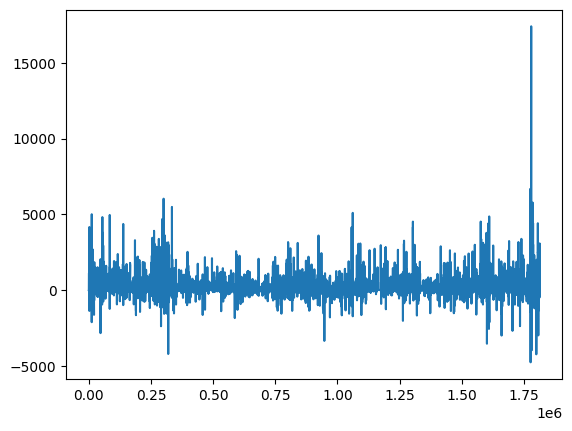

In [18]:
plt.plot(y)

In [19]:
X

array([[            nan,  8.21151910e+00,  8.61727011e+00, ...,
        -8.71444786e-12,  0.00000000e+00,  0.00000000e+00],
       [            nan,  8.21151910e+00,  8.61727011e+00, ...,
         0.00000000e+00,  0.00000000e+00, -1.97211282e-11],
       [            nan,  8.21151910e+00,  8.61727011e+00, ...,
         0.00000000e+00, -1.97211282e-11,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  6.94436735e+00,  9.74305607e+00, ...,
         0.00000000e+00,  0.00000000e+00, -2.35632758e+01],
       [ 0.00000000e+00,  6.94436735e+00,  9.74305607e+00, ...,
         0.00000000e+00, -2.35632758e+01, -2.65888119e+01],
       [ 0.00000000e+00,  6.94436735e+00,  9.74305607e+00, ...,
        -2.35632758e+01, -2.65888119e+01,  0.00000000e+00]],
      shape=(1814374, 180))

In [20]:
print(X.shape)
print(y.shape)

(1814374, 180)
(1814374,)


In [21]:
import os

print("CPUs visibles (os.cpu_count):", os.cpu_count())
print("CPUs assignés par SLURM:", os.environ.get("SLURM_CPUS_ON_NODE"))

CPUs visibles (os.cpu_count): 128
CPUs assignés par SLURM: 16


In [ ]:
!free -h

In [19]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

model = HistGradientBoostingRegressor(
    max_iter=100,
    max_depth=12,
    learning_rate=0.1,
    verbose=1,              # Affiche la progression
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)

model.fit(X, y)

Binning 2.221 GB of training data: 11.760 s
Binning 0.247 GB of validation data: 11.628 s
Fitting gradient boosted rounds:
Fit 100 trees in 1057.620 s, (3100 total leaves)
Time spent computing histograms: 425.588s
Time spent finding best splits:  252.923s
Time spent applying splits:      327.124s
Time spent predicting:           4.145s


HistGradientBoostingRegressor(early_stopping=True, max_depth=12,
                              random_state=42, verbose=1)

In [20]:
# Évaluation
y_pred = model.predict(X)
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("MSE:", mse)
print("R2 :", r2)

MSE: 137561.36368994365
R2 : 0.08260859310476787
